In [1]:
#!/bin/python
import argparse
import pandas as pd
import matplotlib.pyplot as plt
import os
import numpy as np
import sys
import sklearn.model_selection
from sklearn.preprocessing import LabelEncoder
import pickle
import xgboost as xgb
import tensorflow as tf
import numpy as np
from sklearn.model_selection import KFold, train_test_split, GridSearchCV
from sklearn.metrics import confusion_matrix, mean_squared_error, precision_score, accuracy_score


from xgboost import XGBClassifier

# argument parsing 
#parser = argparse.ArgumentParser(description='Process some integers.')
#parser.add_argument('integers', metavar='N', type=int, nargs='+',
#                   help='an integer for the accumulator')
#parser.add_argument('--sum', dest='accumulate', action='store_const',
#                   const=sum, default=max,
#                   help='sum the integers (default: find the max)')

#args = parser.parse_args()
#idx_lr = sys.argv[1]
idx_lr = 1
#idx_md = sys.argv[2]
idx_md = 1

# set seed 
rng = np.random.RandomState(1)

# set directory
os.getcwd()
os.chdir("/ysm-gpfs/pi/zhao/zy92/projects/ddipred/ddi_pred/data")

# list of desired DDI Types
desired_DDI = [0, 1, 2, 3, 4, 5, 6, 7, 15, 16, 17, 18, 19, 20, 21, 22, 26, 28, 30, 31, 32, 38, 40, 41, 43, 44, 45,
               49, 50, 51, 52, 54, 55, 62, 67, 68, 72, 74, 76, 78, 79, 80, 81]


# parameters
parameters = {"learning_rate"    : [0.01, 0.10, 0.25, 0.5, 1 ],
    "max_depth"        : [ 3, 4, 5, 6, 7],
    "min_child_weight" : [ 1, 3, 5, 7 ],
    "gamma"            : [ 0.0, 0.1, 0.2 , 0.3, 0.4 ],
    "colsample_bytree" : [ 0.3, 0.4, 0.5 , 0.7 ] }

# load the data 
ddidata = pd.read_excel("DrugBank_known_ddi.xlsx")
interactiondict = pd.read_csv("Interaction_information.csv")
safe_drugs = pd.read_csv("safe_drug_combos.csv")
drug_similarity_feature = pd.read_csv("drug_similarity.csv")
drug_similarity = drug_similarity_feature.iloc[:, 1:len(drug_similarity_feature)+1]

# filter ddidata for desired DDI types
up_ddidata = ddidata[ddidata.Label.isin(desired_DDI)]
new_ddidata = up_ddidata.copy()

# convert types to int
new_ddidata.drug1 = up_ddidata.drug1.str[2:].astype(int)
new_ddidata.drug2 = up_ddidata.drug2.str[2:].astype(int)
new_ddidata.Label = up_ddidata.Label


# incorporate safe_drugs into new_ddidata with DDIType 0
safe_drugs["Label"] = 0

frames = [safe_drugs, new_ddidata]
ddi_df = pd.concat(frames)

# create a DB to index dictionary from similarity dataset
DB_to_index = {}
i = 0
for col in drug_similarity.columns:
    DB_to_index[int(col[2:7])] = i
    i = i + 1

# filter output to only include DBs with similarity features
ddi_df_output = ddi_df[ddi_df.drug1.isin(DB_to_index)]
ddi_output = ddi_df_output[ddi_df_output.drug2.isin(DB_to_index)]

# filter out the duplicate samples
bool_series_to_delete = ddi_output[['drug1', 'drug2']].duplicated()
ddi_clean = ddi_output[~bool_series_to_delete]


# feature building 
# add similarity feature for each drug-drug pair
n_similarity = 2159
sim_array = np.empty([ddi_clean.shape[0], 2*n_similarity], dtype='float16')
i = 0
for index, (_, row) in enumerate(ddi_clean.iterrows()):
    if index % 10000 == 0:
        print("INFO: iter " + str(index + 1))
    drug1_index = DB_to_index[row["drug1"]]
    drug2_index = DB_to_index[row["drug2"]]
    feature_vec = np.hstack([drug_similarity.iloc[:,drug1_index],drug_similarity.iloc[:,drug2_index]])
    sim_array[index, ] = feature_vec
    
# create input and output vectors for training

X_data = sim_array
y_data = np.array(ddi_clean.Label)

# transform the y
encoder = LabelEncoder()
encoder.fit(y_data)
encoded_Y = encoder.transform(y_data)

#y_data = tf.keras.utils.to_categorical(encoded_Y)
y_data = encoded_Y

X_train, X_test, y_train, y_test = sklearn.model_selection.train_test_split(X_data, y_data, test_size = 0.3
                                                                           , random_state = 1)
X_test, X_val, y_test, y_val = sklearn.model_selection.train_test_split(X_test, y_test, test_size = 0.5
                                                                       , random_state = 1)

# dmatrix
dtrain = xgb.DMatrix(X_train, label = y_train)
dtest = xgb.DMatrix(X_test, label = y_test)
dval = xgb.DMatrix(X_val, label = y_val)

print("----- INFO: training data preprocess is done. -----")

INFO: iter 1
INFO: iter 10001
INFO: iter 20001
INFO: iter 30001
INFO: iter 40001
INFO: iter 50001
INFO: iter 60001
INFO: iter 70001
INFO: iter 80001
INFO: iter 90001
INFO: iter 100001
----- INFO: training data preprocess is done. -----


In [2]:
# parameters
parameters = {"learning_rate"    : [0.10, 0.25, 0.5, 1 ],
    "max_depth"        : [ 4, 5, 6, 7],
    "min_child_weight" : [ 1, 3, 5, 7 ],
    "gamma"            : [ 0.0, 0.1, 0.2 , 0.3, 0.4 ],
    "colsample_bytree" : [ 0.3, 0.4, 0.5 , 0.7 ] }

In [23]:
# param
output_dir = "/ysm-gpfs/pi/zhao/zy92/projects/ddipred/ddi_pred/code/xgboost/output/"
model_dict = {}
count = 0
for i in range(4):
    for j in range(4):
        print("INFO: " + "processing number" + str(count + 1))
        learning_rate = parameters["learning_rate"][i]
        max_depth = parameters["max_depth"][j]
        count += 1
        history_path = output_dir + "_lr_" + str(learning_rate) + "_md_" + str(max_depth) + "_history_dict.pickle"
        model_path = output_dir + "_lr_" + str(learning_rate) + "_md_" + str(max_depth) + "_xgb.pickle"
        history_fo = open(history_path, "rb")
        model_fo = open(model_path, "rb")
        history_dict = pickle.load(history_fo)
        bst = pickle.load(model_fo)
        # load the object from the file into var b
        model_dict[count] = {'model': bst,
                             'history': history_dict}
        history_fo.close()
        model_fo.close()

INFO: processing number1
INFO: processing number2
INFO: processing number3
INFO: processing number4
INFO: processing number5
INFO: processing number6
INFO: processing number7
INFO: processing number8
INFO: processing number9
INFO: processing number10
INFO: processing number11
INFO: processing number12
INFO: processing number13
INFO: processing number14
INFO: processing number15
INFO: processing number16


In [11]:
model_dict[1]['history']['train']

{'merror': [0.230888,
  0.186444,
  0.168081,
  0.156372,
  0.14948,
  0.140992,
  0.133975,
  0.127041,
  0.121243,
  0.117559,
  0.114547,
  0.11106,
  0.107586,
  0.103776,
  0.099826,
  0.097669,
  0.094784,
  0.092291,
  0.089209,
  0.085988,
  0.083158,
  0.080525,
  0.078326,
  0.076295,
  0.074054,
  0.072387,
  0.070608,
  0.068703,
  0.06684,
  0.065075],
 'mlogloss': [1.4316,
  1.11637,
  0.938264,
  0.80793,
  0.719506,
  0.648648,
  0.58746,
  0.535616,
  0.494667,
  0.459511,
  0.43197,
  0.406748,
  0.384339,
  0.362965,
  0.343717,
  0.328915,
  0.315362,
  0.301526,
  0.289879,
  0.278335,
  0.268389,
  0.260126,
  0.252401,
  0.245388,
  0.238549,
  0.232414,
  0.226294,
  0.220372,
  0.214846,
  0.210097]}

dict_keys(['validation', 'test', 'train'])


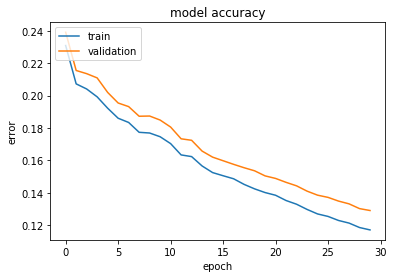

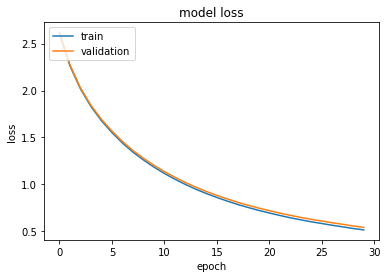

In [24]:
# list all data in history
history = model_dict[1]["history"]
print(history.keys())
# summarize history for accuracy
#convert_func = lambda x: 1-x
plt.plot([x for x in history['train']['merror']])
plt.plot([x for x in history['validation']['merror']])
plt.title('model accuracy')
plt.ylabel('error')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history['train']['mlogloss'])
plt.plot(history['validation']['mlogloss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

dict_keys(['validation', 'test', 'train'])


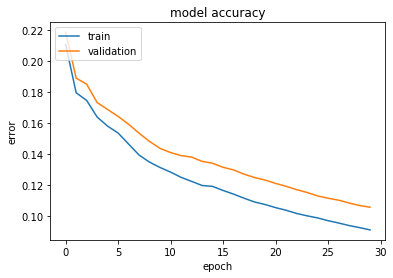

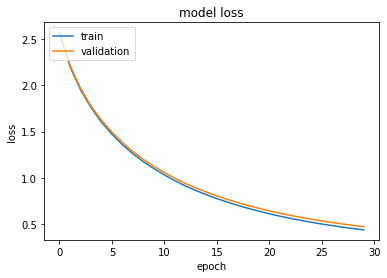

In [25]:
# list all data in history
history = model_dict[2]["history"]
print(history.keys())
# summarize history for accuracy
#convert_func = lambda x: 1-x
plt.plot([x for x in history['train']['merror']])
plt.plot([x for x in history['validation']['merror']])
plt.title('model accuracy')
plt.ylabel('error')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history['train']['mlogloss'])
plt.plot(history['validation']['mlogloss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

dict_keys(['validation', 'test', 'train'])


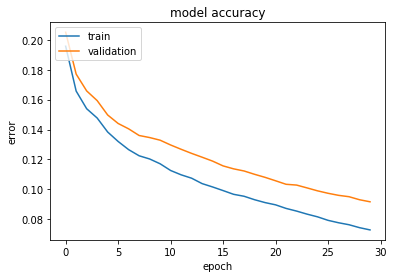

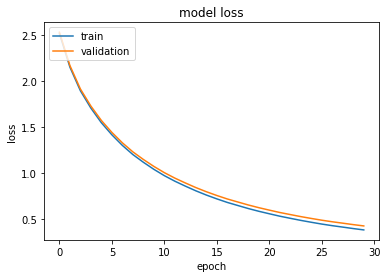

In [26]:
# list all data in history
history = model_dict[3]["history"]
print(history.keys())
# summarize history for accuracy
#convert_func = lambda x: 1-x
plt.plot([x for x in history['train']['merror']])
plt.plot([x for x in history['validation']['merror']])
plt.title('model accuracy')
plt.ylabel('error')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history['train']['mlogloss'])
plt.plot(history['validation']['mlogloss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

dict_keys(['validation', 'test', 'train'])


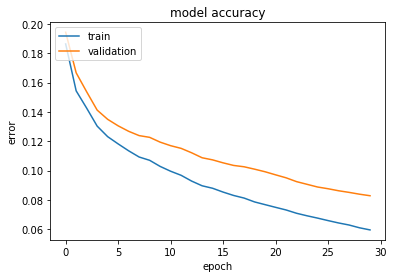

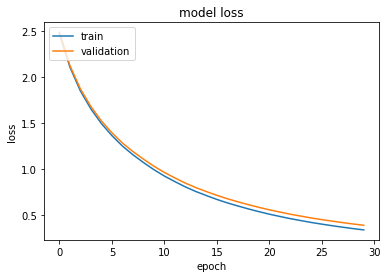

In [27]:
# list all data in history
history = model_dict[4]["history"]
print(history.keys())
# summarize history for accuracy
#convert_func = lambda x: 1-x
plt.plot([x for x in history['train']['merror']])
plt.plot([x for x in history['validation']['merror']])
plt.title('model accuracy')
plt.ylabel('error')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history['train']['mlogloss'])
plt.plot(history['validation']['mlogloss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

dict_keys(['validation', 'test', 'train'])


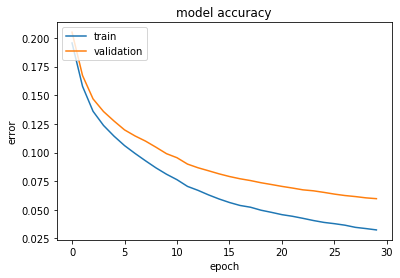

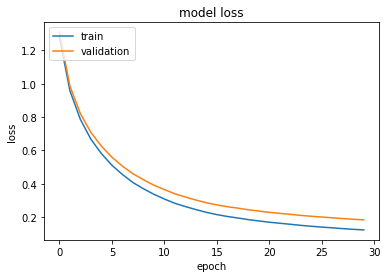

In [53]:
# list all data in history
history = model_dict[7]["history"]
print(history.keys())
# summarize history for accuracy
#convert_func = lambda x: 1-x
plt.plot([x for x in history['train']['merror']])
plt.plot([x for x in history['validation']['merror']])
plt.title('model accuracy')
plt.ylabel('error')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history['train']['mlogloss'])
plt.plot(history['validation']['mlogloss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

dict_keys(['validation', 'test', 'train'])


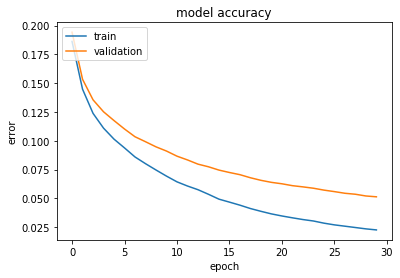

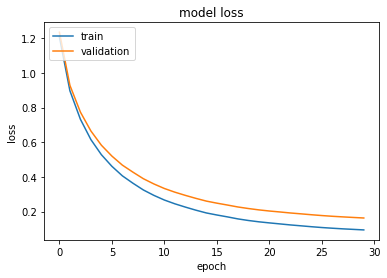

In [54]:
# list all data in history
history = model_dict[8]["history"]
print(history.keys())
# summarize history for accuracy
#convert_func = lambda x: 1-x
plt.plot([x for x in history['train']['merror']])
plt.plot([x for x in history['validation']['merror']])
plt.title('model accuracy')
plt.ylabel('error')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history['train']['mlogloss'])
plt.plot(history['validation']['mlogloss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

In [49]:
model_dict[16]["history"]["test"]["merror"]

[0.194653, 0.787241, 0.558991, 0.696189, 0.532322]

In [50]:
test_vec = []
val_vec = []
train_vec = []
for i in range(1, 17):
    test_vec.append(model_dict[i]["history"]["test"]["merror"][-1]) 
    val_vec.append(model_dict[i]["history"]["validation"]["merror"][-1]) 
    train_vec.append(model_dict[i]["history"]["train"]["merror"][-1]) 

In [57]:
idx = 7
print(1 - train_vec[idx])
print(1 - test_vec[idx])
print(1 - val_vec[idx])

0.977449
0.94797
0.948689


In [52]:
val_vec

[0.129093,
 0.105497,
 0.091705,
 0.082816,
 0.08092,
 0.071573,
 0.059742,
 0.051311,
 0.281718,
 0.295183,
 0.291065,
 0.329433,
 0.561082,
 0.700373,
 0.402641,
 0.531146]

In [16]:
model_dict[4]["history"]

{'validation': {'merror': [0.239101,
   0.195307,
   0.178574,
   0.166678,
   0.16086,
   0.150533,
   0.144192,
   0.137199,
   0.132231,
   0.127851,
   0.125302,
   0.122296,
   0.119093,
   0.115563,
   0.112295,
   0.109615,
   0.106478,
   0.103994,
   0.102033,
   0.098765,
   0.095627,
   0.093862,
   0.091901,
   0.089941,
   0.088241,
   0.086411,
   0.08543,
   0.083077,
   0.082032,
   0.08092],
  'mlogloss': [1.45318,
   1.138941,
   0.963364,
   0.833054,
   0.746361,
   0.677328,
   0.618566,
   0.56745,
   0.52776,
   0.493525,
   0.466553,
   0.442212,
   0.420036,
   0.399189,
   0.380351,
   0.366194,
   0.353042,
   0.339456,
   0.328317,
   0.317332,
   0.307659,
   0.299666,
   0.292075,
   0.285407,
   0.278978,
   0.27329,
   0.267427,
   0.261768,
   0.256468,
   0.251766]},
 'test': {'merror': [0.234852,
   0.194588,
   0.176351,
   0.165436,
   0.159422,
   0.150794,
   0.144389,
   0.138702,
   0.134126,
   0.128701,
   0.125368,
   0.121773,
   0.118504,
 

In [17]:
model_dict[3]["history"]

{'validation': {'merror': [0.239101,
   0.195307,
   0.178574,
   0.166678,
   0.16086,
   0.150533,
   0.144192,
   0.137199,
   0.132231,
   0.127851,
   0.125302,
   0.122296,
   0.119093,
   0.115563,
   0.112295,
   0.109615,
   0.106478,
   0.103994,
   0.102033,
   0.098765,
   0.095627,
   0.093862,
   0.091901,
   0.089941,
   0.088241,
   0.086411,
   0.08543,
   0.083077,
   0.082032,
   0.08092],
  'mlogloss': [1.45318,
   1.138941,
   0.963364,
   0.833054,
   0.746361,
   0.677328,
   0.618566,
   0.56745,
   0.52776,
   0.493525,
   0.466553,
   0.442212,
   0.420036,
   0.399189,
   0.380351,
   0.366194,
   0.353042,
   0.339456,
   0.328317,
   0.317332,
   0.307659,
   0.299666,
   0.292075,
   0.285407,
   0.278978,
   0.27329,
   0.267427,
   0.261768,
   0.256468,
   0.251766]},
 'test': {'merror': [0.234852,
   0.194588,
   0.176351,
   0.165436,
   0.159422,
   0.150794,
   0.144389,
   0.138702,
   0.134126,
   0.128701,
   0.125368,
   0.121773,
   0.118504,
 